# Training

Test different pipeline primarily using the linear model response to feature engineering efforts.

In [1]:

import logging
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from src import utils
from src.modelling import transforms
from src.modelling import training
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
experiments = {}
model_names = ['linear_model', 'xgboost']
n_tuning_trials = 3
test_size = 0.01

## Baseline

In [3]:
experiment_name = 'baseline'
proj_root = utils.get_proj_root()

config = utils.get_config('config/config.ini')

def make_pipeline():

    categorical_column_names = ['hour', 'month']
    columns_to_drop = ['date', 'hour', 'datetime']

    temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['temperature_columns'])
    optimal_temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])

    

    pipeline = Pipeline(
            steps=[
                ("select_optimal_temperature_columns", transforms.OptimalTemperatureSelector(
                    temperature_column_names_path=temperature_column_names_path,
                    optimal_temperature_column_names_path=optimal_temperature_column_names_path)  
                ),
                ("create_weekend_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_weekend', 
                                                            derive_func=transforms.is_weekend)
                                                            ),
                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                ("create_holiday_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_holiday', 
                                                            derive_func=transforms.is_holiday)
                                                            ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )
    return pipeline

def main(model_name:str, pipeline, n_tuning_trials=1):
    logger = logging.getLogger(__name__)
    proj_root = utils.get_proj_root()

    config = utils.get_config('config/config.ini')

    model_output_dir = proj_root.joinpath(config["modelling_paths"]["model_output"])
    preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])

    label_col_name = 'load'
    model_params = config._sections[model_name]
    model_class = training.get_model_class(model_name=model_name)
    model = model_class(**model_params)



    preprocessed_data = training.get_training_data(file_path=preprocessed_data_path)
    training_data, testing_data = train_test_split(preprocessed_data, test_size=test_size, shuffle=False)



    model_output_path = model_output_dir.joinpath(model_name + ".pkl")
    trainer = training.ModelTrainer(
        model_class=model,
        transform_pipeline=pipeline,
        training_data=training_data,
        testing_data=testing_data,
        label_col_name=label_col_name,
        model_output_path=model_output_path
    )

    logger.info("==============tuning started=============")
    trainer.tune_model(n_trials=n_tuning_trials)
    # logger.info('tuning completed')
    logger.info("==============training started====================")
    model = trainer.train_model(save_model=True)
    logger.info("==========training completed===============")
    logger.info("==========evaluation===============")
    score = trainer.evaluate_model()
    print(f"test score:{score}")
    logger.info(f"test score:{score}")
    score = trainer.inf_model()
    print(f"test score:{score}")
    logger.info(f"inf score:{score}")
    logger.info("==========evaluation completed===============")

    return model, score

model_results = {}

for model_name in model_names:

    pipeline = make_pipeline()
    model, score = main(model_name=model_name, pipeline=pipeline, n_tuning_trials=n_tuning_trials)
    model_results[model_name] = model, score

experiments[experiment_name] = model_results


[I 2024-06-04 14:15:35,219] A new study created in memory with name: no-name-8df97d89-02fa-4b0d-a80e-67f5fe6f182c
[I 2024-06-04 14:15:35,619] Trial 0 finished with value: -0.22775005031517664 and parameters: {'alpha': 0.1364003312843786}. Best is trial 0 with value: -0.22775005031517664.


Trial 0, alpha: 0.1364003312843786,  mape: 0.22775005031517664


[I 2024-06-04 14:15:36,041] Trial 1 finished with value: -0.22736444298518327 and parameters: {'alpha': 1.3135702945145085}. Best is trial 1 with value: -0.22736444298518327.


Trial 1, alpha: 1.3135702945145085,  mape: 0.22736444298518327


[I 2024-06-04 14:15:36,453] Trial 2 finished with value: -0.2277057042531478 and parameters: {'alpha': 0.26988712770578543}. Best is trial 1 with value: -0.22736444298518327.


Trial 2, alpha: 0.26988712770578543,  mape: 0.2277057042531478
best score is: -0.22736444298518327
test score:0.11029629101438387
test score:0.11029629101438387


[I 2024-06-04 14:15:36,713] A new study created in memory with name: no-name-1f5efbcf-19c3-4923-ae50-a1a747a2f56d
[I 2024-06-04 14:15:43,910] Trial 0 finished with value: -0.13330183717077546 and parameters: {'n_estimators': 109, 'max_depth': 50, 'learning_rate': 0.00803203409411526, 'min_child_weight': 10, 'subsample': 0.6858157949422834, 'gamma': 0.8743142839836295, 'reg_alpha': 0.23693984834398074, 'reg_lambda': 0.22852979343829316}. Best is trial 0 with value: -0.13330183717077546.


Trial 0, n_estimators: 109, max_depth: 50, learning_rate: 0.00803203409411526,min_child_weight: 10, subsample: 0.6858157949422834 gamma: 0.8743142839836295, reg_alpha: 0.23693984834398074, reg_lambda: 0.22852979343829316, mape: 0.13330183717077546


[I 2024-06-04 14:15:45,171] Trial 1 finished with value: -0.2236798540700594 and parameters: {'n_estimators': 67, 'max_depth': 9, 'learning_rate': 0.003360653477421308, 'min_child_weight': 3, 'subsample': 0.7845973988027387, 'gamma': 0.6362465279114764, 'reg_alpha': 0.034039722751642354, 'reg_lambda': 0.414343142383643}. Best is trial 0 with value: -0.13330183717077546.


Trial 1, n_estimators: 67, max_depth: 9, learning_rate: 0.003360653477421308,min_child_weight: 3, subsample: 0.7845973988027387 gamma: 0.6362465279114764, reg_alpha: 0.034039722751642354, reg_lambda: 0.414343142383643, mape: 0.2236798540700594


[I 2024-06-04 14:15:47,314] Trial 2 finished with value: -0.2507441125517521 and parameters: {'n_estimators': 41, 'max_depth': 24, 'learning_rate': 0.0014581888044533056, 'min_child_weight': 5, 'subsample': 0.5261350225536545, 'gamma': 0.4373634875395003, 'reg_alpha': 0.795388735291751, 'reg_lambda': 0.8892583658484765}. Best is trial 0 with value: -0.13330183717077546.


Trial 2, n_estimators: 41, max_depth: 24, learning_rate: 0.0014581888044533056,min_child_weight: 5, subsample: 0.5261350225536545 gamma: 0.4373634875395003, reg_alpha: 0.795388735291751, reg_lambda: 0.8892583658484765, mape: 0.2507441125517521
best score is: -0.13330183717077546
test score:0.09573206573635225
test score:0.09573206573635225


## Add higer order temperature

In [4]:

experiment_name = 'higher_order_temperature'


def make_pipeline():

    categorical_column_names = ['hour', 'month']
    columns_to_drop = ['date', 'hour', 'datetime', 'mean_temp']

    temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['temperature_columns'])
    optimal_temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])
    optimal_temperature_column_names = utils.load_value(optimal_temperature_column_names_path)
    # daily_load_profile_path = proj_root.joinpath(config['modelling_paths']['daily_load_profile_feature'])
    print(optimal_temperature_column_names)



    pipeline = Pipeline(
            steps=[
                ("select_optimal_temperature_columns", transforms.OptimalTemperatureSelector(
                    temperature_column_names_path=temperature_column_names_path,
                    optimal_temperature_column_names_path=optimal_temperature_column_names_path)  
                ),
                ("create_weekend_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_weekend', 
                                                            derive_func=transforms.is_weekend)
                                                            ),
                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                ("create_holiday_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_holiday', 
                                                            derive_func=transforms.is_holiday)
                                                            ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                ("create_mean_temperature",transforms.DerivedColumnTransformer(column_name=optimal_temperature_column_names, 
                                                            new_column_name='mean_temp', 
                                                            derive_func=np.mean, func_kwargs={'axis':1})
                                                            ),
                
                ("create_temperature_squared",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_sq', 
                                                            derive_func=np.square)
                                                            ),
                ("create_temperature_cube",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_cube', 
                                                            derive_func=transforms.exp_value, func_kwargs={'exp':3})
                                                            ),
                ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )
    return pipeline

def main(model_name:str, pipeline, n_tuning_trials=1):
    logger = logging.getLogger(__name__)
    proj_root = utils.get_proj_root()

    config = utils.get_config('config/config.ini')

    model_output_dir = proj_root.joinpath(config["modelling_paths"]["model_output"])
    preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])

    label_col_name = 'load'
    model_params = config._sections[model_name]
    model_class = training.get_model_class(model_name=model_name)
    model = model_class(**model_params)



    preprocessed_data = training.get_training_data(file_path=preprocessed_data_path)
    training_data, testing_data = train_test_split(preprocessed_data, test_size=test_size, shuffle=False)



    model_output_path = model_output_dir.joinpath(model_name + ".pkl")
    trainer = training.ModelTrainer(
        model_class=model,
        transform_pipeline=pipeline,
        training_data=training_data,
        testing_data=testing_data,
        label_col_name=label_col_name,
        model_output_path=model_output_path
    )

    logger.info("==============tuning started=============")
    trainer.tune_model(n_trials=n_tuning_trials)
    # logger.info('tuning completed')
    logger.info("==============training started====================")
    model = trainer.train_model(save_model=True)
    logger.info("==========training completed===============")
    logger.info("==========evaluation===============")
    score = trainer.evaluate_model()
    print(f"test score:{score}")
    logger.info(f"test score:{score}")
    score = trainer.inf_model()
    print(f"test score:{score}")
    logger.info(f"inf score:{score}")
    logger.info("==========evaluation completed===============")

    return model, score

model_results = {}

for model_name in model_names:

    pipeline = make_pipeline()
    model, score = main(model_name=model_name, pipeline=pipeline, n_tuning_trials=n_tuning_trials)
    model_results[model_name] = model, score

experiments[experiment_name] = model_results

[I 2024-06-04 14:15:48,994] A new study created in memory with name: no-name-b134e432-3b2b-4271-b1f0-3a323133e586


['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-06-04 14:15:49,539] Trial 0 finished with value: -0.09517936038070277 and parameters: {'alpha': 2.0441966523305086}. Best is trial 0 with value: -0.09517936038070277.


Trial 0, alpha: 2.0441966523305086,  mape: 0.09517936038070277


[I 2024-06-04 14:15:50,027] Trial 1 finished with value: -0.09518229939648207 and parameters: {'alpha': 0.9502886635392516}. Best is trial 0 with value: -0.09517936038070277.


Trial 1, alpha: 0.9502886635392516,  mape: 0.09518229939648207


[I 2024-06-04 14:15:50,533] Trial 2 finished with value: -0.09518645164701571 and parameters: {'alpha': 0.2198996101425072}. Best is trial 0 with value: -0.09517936038070277.


Trial 2, alpha: 0.2198996101425072,  mape: 0.09518645164701571
best score is: -0.09517936038070277
test score:0.08493137038241123
test score:0.08493137038241123
['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-06-04 14:15:50,818] A new study created in memory with name: no-name-ab16c90b-dd41-4786-9615-64642cd25aa9
[I 2024-06-04 14:16:00,573] Trial 0 finished with value: -0.07915206219301471 and parameters: {'n_estimators': 112, 'max_depth': 33, 'learning_rate': 0.04288536175868024, 'min_child_weight': 5, 'subsample': 0.6554895716344628, 'gamma': 0.6478398054817487, 'reg_alpha': 0.5840109089459128, 'reg_lambda': 0.749410681190565}. Best is trial 0 with value: -0.07915206219301471.


Trial 0, n_estimators: 112, max_depth: 33, learning_rate: 0.04288536175868024,min_child_weight: 5, subsample: 0.6554895716344628 gamma: 0.6478398054817487, reg_alpha: 0.5840109089459128, reg_lambda: 0.749410681190565, mape: 0.07915206219301471


[I 2024-06-04 14:16:01,949] Trial 1 finished with value: -0.23879502024959748 and parameters: {'n_estimators': 17, 'max_depth': 19, 'learning_rate': 0.006516693739948062, 'min_child_weight': 5, 'subsample': 0.7479262216124778, 'gamma': 0.09503947621120601, 'reg_alpha': 0.6911594920351875, 'reg_lambda': 0.008335385406266882}. Best is trial 0 with value: -0.07915206219301471.


Trial 1, n_estimators: 17, max_depth: 19, learning_rate: 0.006516693739948062,min_child_weight: 5, subsample: 0.7479262216124778 gamma: 0.09503947621120601, reg_alpha: 0.6911594920351875, reg_lambda: 0.008335385406266882, mape: 0.23879502024959748


[I 2024-06-04 14:16:02,475] Trial 2 finished with value: -0.23820565855995954 and parameters: {'n_estimators': 42, 'max_depth': 3, 'learning_rate': 0.004532225408826302, 'min_child_weight': 8, 'subsample': 0.8644260081123326, 'gamma': 0.7847158300387864, 'reg_alpha': 0.3587612072747598, 'reg_lambda': 0.6831526028387538}. Best is trial 0 with value: -0.07915206219301471.


Trial 2, n_estimators: 42, max_depth: 3, learning_rate: 0.004532225408826302,min_child_weight: 8, subsample: 0.8644260081123326 gamma: 0.7847158300387864, reg_alpha: 0.3587612072747598, reg_lambda: 0.6831526028387538, mape: 0.23820565855995954
best score is: -0.07915206219301471
test score:0.0766242820146314
test score:0.0766242820146314


## Create interactions

In [5]:

experiment_name = 'model interactions'


def make_pipeline():

    categorical_column_names = ['hour', 'month']
    columns_to_drop = ['date', 'hour', 'datetime', 'mean_temp']

    temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['temperature_columns'])
    optimal_temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])
    optimal_temperature_column_names = utils.load_value(optimal_temperature_column_names_path)
    # daily_load_profile_path = proj_root.joinpath(config['modelling_paths']['daily_load_profile_feature'])
    print(optimal_temperature_column_names)

    daily_load_profile_path = proj_root.joinpath(
        config["modelling_paths"]["daily_load_profile_feature"]
    )


    pipeline = Pipeline(
            steps=[
                ("select_optimal_temperature_columns", transforms.OptimalTemperatureSelector(
                    temperature_column_names_path=temperature_column_names_path,
                    optimal_temperature_column_names_path=optimal_temperature_column_names_path)  
                ),
                ("create_weekend_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_weekend', 
                                                            derive_func=transforms.is_weekend)
                                                            ),
                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                ("create_holiday_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_holiday', 
                                                            derive_func=transforms.is_holiday)
                                                            ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                ("create_mean_temperature",transforms.DerivedColumnTransformer(column_name=optimal_temperature_column_names, 
                                                            new_column_name='mean_temp', 
                                                            derive_func=np.mean, func_kwargs={'axis':1})
                                                            ),
                
                ("create_temperature_squared",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_sq', 
                                                            derive_func=np.square)
                                                            ),
                ("create_temperature_cube",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_cube', 
                                                            derive_func=transforms.exp_value, func_kwargs={'exp':3})
                                                            ),

            (
                "create_interaction_temp_hour_profile_2", transforms.MultiColumnTransformer(
                    column_names=["mean_temp", "hour"],
                    new_column_name="temp_hour_p2",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_interaction_temp_month",
                transforms.MultiColumnTransformer(
                    column_names=["mean_temp", "month"],
                    new_column_name="temp_month",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_interaction_month_hour",
                transforms.MultiColumnTransformer(
                    column_names=["month", "hour"],
                    new_column_name="month_hour",
                    derive_func=transforms.multiply_columns,
                ),
            ),

                ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )
    return pipeline

def main(model_name:str, pipeline, n_tuning_trials=1):
    logger = logging.getLogger(__name__)
    proj_root = utils.get_proj_root()

    config = utils.get_config('config/config.ini')

    model_output_dir = proj_root.joinpath(config["modelling_paths"]["model_output"])
    preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])

    label_col_name = 'load'
    model_params = config._sections[model_name]
    model_class = training.get_model_class(model_name=model_name)
    model = model_class(**model_params)



    preprocessed_data = training.get_training_data(file_path=preprocessed_data_path)
    training_data, testing_data = train_test_split(preprocessed_data, test_size=test_size, shuffle=False)



    model_output_path = model_output_dir.joinpath(model_name + ".pkl")
    trainer = training.ModelTrainer(
        model_class=model,
        transform_pipeline=pipeline,
        training_data=training_data,
        testing_data=testing_data,
        label_col_name=label_col_name,
        model_output_path=model_output_path
    )

    logger.info("==============tuning started=============")
    trainer.tune_model(n_trials=n_tuning_trials)
    # logger.info('tuning completed')
    logger.info("==============training started====================")
    model = trainer.train_model(save_model=True)
    logger.info("==========training completed===============")
    logger.info("==========evaluation===============")
    score = trainer.evaluate_model()
    print(f"test score:{score}")
    logger.info(f"test score:{score}")
    score = trainer.inf_model()
    print(f"test score:{score}")
    logger.info(f"inf score:{score}")
    logger.info("==========evaluation completed===============")

    return model, score

model_results = {}

for model_name in model_names:

    pipeline = make_pipeline()
    model, score = main(model_name=model_name, pipeline=pipeline, n_tuning_trials=n_tuning_trials)
    model_results[model_name] = model, score

experiments[experiment_name] = model_results

[I 2024-06-04 14:16:05,533] A new study created in memory with name: no-name-1156995a-303d-4e51-97ac-eab2310aa568


['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-06-04 14:16:06,102] Trial 0 finished with value: -0.10211097835076499 and parameters: {'alpha': 1.8953438322052796}. Best is trial 0 with value: -0.10211097835076499.


Trial 0, alpha: 1.8953438322052796,  mape: 0.10211097835076499


[I 2024-06-04 14:16:06,645] Trial 1 finished with value: -0.10239756836595308 and parameters: {'alpha': 0.1729348178749224}. Best is trial 0 with value: -0.10211097835076499.


Trial 1, alpha: 0.1729348178749224,  mape: 0.10239756836595308


[I 2024-06-04 14:16:07,273] Trial 2 finished with value: -0.10234998788164096 and parameters: {'alpha': 0.4287300472273902}. Best is trial 0 with value: -0.10211097835076499.


Trial 2, alpha: 0.4287300472273902,  mape: 0.10234998788164096
best score is: -0.10211097835076499
test score:0.08256530800081892


[I 2024-06-04 14:16:07,663] A new study created in memory with name: no-name-32b2a34f-48b8-4dd1-8400-24d99f1717f5


test score:0.08256530800081892
['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-06-04 14:16:12,394] Trial 0 finished with value: -0.20260599802910645 and parameters: {'n_estimators': 94, 'max_depth': 14, 'learning_rate': 0.0035880108349672316, 'min_child_weight': 4, 'subsample': 0.6016361709913735, 'gamma': 0.689749688646242, 'reg_alpha': 0.2443346042935638, 'reg_lambda': 0.4284370252248637}. Best is trial 0 with value: -0.20260599802910645.


Trial 0, n_estimators: 94, max_depth: 14, learning_rate: 0.0035880108349672316,min_child_weight: 4, subsample: 0.6016361709913735 gamma: 0.689749688646242, reg_alpha: 0.2443346042935638, reg_lambda: 0.4284370252248637, mape: 0.20260599802910645


[I 2024-06-04 14:16:12,962] Trial 1 finished with value: -0.17375539616095953 and parameters: {'n_estimators': 44, 'max_depth': 3, 'learning_rate': 0.021085167606983306, 'min_child_weight': 4, 'subsample': 0.8813734542971978, 'gamma': 0.5687963286775326, 'reg_alpha': 0.043330494404463016, 'reg_lambda': 0.18882964214267683}. Best is trial 1 with value: -0.17375539616095953.


Trial 1, n_estimators: 44, max_depth: 3, learning_rate: 0.021085167606983306,min_child_weight: 4, subsample: 0.8813734542971978 gamma: 0.5687963286775326, reg_alpha: 0.043330494404463016, reg_lambda: 0.18882964214267683, mape: 0.17375539616095953


[I 2024-06-04 14:16:18,093] Trial 2 finished with value: -0.1438932873633048 and parameters: {'n_estimators': 48, 'max_depth': 15, 'learning_rate': 0.018198588430313408, 'min_child_weight': 1, 'subsample': 0.9977424387183615, 'gamma': 0.45736602739780396, 'reg_alpha': 0.06977894671530349, 'reg_lambda': 0.9730390241749355}. Best is trial 2 with value: -0.1438932873633048.


Trial 2, n_estimators: 48, max_depth: 15, learning_rate: 0.018198588430313408,min_child_weight: 1, subsample: 0.9977424387183615 gamma: 0.45736602739780396, reg_alpha: 0.06977894671530349, reg_lambda: 0.9730390241749355, mape: 0.1438932873633048
best score is: -0.1438932873633048
test score:0.09270897382933263
test score:0.09270897382933263


## Engineer non-linear features

In [6]:

experiment_name = 'encode non-linearities'


def make_pipeline():

    categorical_column_names = ['hour', 'month']
    columns_to_drop = ['date', 'hour', 'datetime', 'mean_temp']

    temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['temperature_columns'])
    optimal_temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])
    optimal_temperature_column_names = utils.load_value(optimal_temperature_column_names_path)
    # daily_load_profile_path = proj_root.joinpath(config['modelling_paths']['daily_load_profile_feature'])
    print(optimal_temperature_column_names)

    daily_load_profile_path = proj_root.joinpath(
        config["modelling_paths"]["daily_load_profile_feature"]
    )


    pipeline = Pipeline(
            steps=[
                ("select_optimal_temperature_columns", transforms.OptimalTemperatureSelector(
                    temperature_column_names_path=temperature_column_names_path,
                    optimal_temperature_column_names_path=optimal_temperature_column_names_path)  
                ),
                ("create_weekend_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_weekend', 
                                                            derive_func=transforms.is_weekend)
                                                            ),
                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                ("create_holiday_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_holiday', 
                                                            derive_func=transforms.is_holiday)
                                                            ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                ("create_mean_temperature",transforms.DerivedColumnTransformer(column_name=optimal_temperature_column_names, 
                                                            new_column_name='mean_temp', 
                                                            derive_func=np.mean, func_kwargs={'axis':1})
                                                            ),
                
                ("create_temperature_squared",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_sq', 
                                                            derive_func=np.square)
                                                            ),
                ("create_temperature_cube",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_cube', 
                                                            derive_func=transforms.exp_value, func_kwargs={'exp':3})
                                                            ),

            (
                "create_interaction_temp_hour_profile_2", transforms.MultiColumnTransformer(
                    column_names=["mean_temp", "hour"],
                    new_column_name="temp_hour_p2",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_interaction_temp_month",
                transforms.MultiColumnTransformer(
                    column_names=["mean_temp", "month"],
                    new_column_name="temp_month",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_interaction_month_hour",
                transforms.MultiColumnTransformer(
                    column_names=["month", "hour"],
                    new_column_name="month_hour",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_non_linear_hour_features",
                transforms.HourlyProfileTransformer(
                    datetime_column_name="datetime",
                    feature_path=daily_load_profile_path,
                ),
            ),
            (
                "create_interaction_month_hour_profile_1",
                transforms.MultiColumnTransformer(
                    column_names=["month", "profile_1"],
                    new_column_name="month_hour_p1",
                    derive_func=transforms.multiply_columns,
                ),
            ),

                ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )
    return pipeline

def main(model_name:str, pipeline, n_tuning_trials=1):
    logger = logging.getLogger(__name__)
    proj_root = utils.get_proj_root()

    config = utils.get_config('config/config.ini')

    model_output_dir = proj_root.joinpath(config["modelling_paths"]["model_output"])
    preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])

    label_col_name = 'load'
    model_params = config._sections[model_name]
    model_class = training.get_model_class(model_name=model_name)
    model = model_class(**model_params)



    preprocessed_data = training.get_training_data(file_path=preprocessed_data_path)
    training_data, testing_data = train_test_split(preprocessed_data, test_size=test_size, shuffle=False)



    model_output_path = model_output_dir.joinpath(model_name + ".pkl")
    trainer = training.ModelTrainer(
        model_class=model,
        transform_pipeline=pipeline,
        training_data=training_data,
        testing_data=testing_data,
        label_col_name=label_col_name,
        model_output_path=model_output_path
    )

    logger.info("==============tuning started=============")
    trainer.tune_model(n_trials=n_tuning_trials)
    # logger.info('tuning completed')
    logger.info("==============training started====================")
    model = trainer.train_model(save_model=True)
    logger.info("==========training completed===============")
    logger.info("==========evaluation===============")
    score = trainer.evaluate_model()
    print(f"test score:{score}")
    logger.info(f"test score:{score}")
    score = trainer.inf_model()
    print(f"test score:{score}")
    logger.info(f"inf score:{score}")
    logger.info("==========evaluation completed===============")

    return model, score

model_results = {}

for model_name in model_names:

    pipeline = make_pipeline()
    model, score = main(model_name=model_name, pipeline=pipeline, n_tuning_trials=n_tuning_trials)
    model_results[model_name] = model, score

experiments[experiment_name] = model_results

[I 2024-06-04 14:16:20,306] A new study created in memory with name: no-name-b2b2e2d1-ee59-45e8-9272-c590eeba3b20


['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-06-04 14:16:20,959] Trial 0 finished with value: -0.10065925545026407 and parameters: {'alpha': 4.542516827118303}. Best is trial 0 with value: -0.10065925545026407.


Trial 0, alpha: 4.542516827118303,  mape: 0.10065925545026407


[I 2024-06-04 14:16:21,637] Trial 1 finished with value: -0.10149328907196975 and parameters: {'alpha': 0.46271080240711493}. Best is trial 0 with value: -0.10065925545026407.


Trial 1, alpha: 0.46271080240711493,  mape: 0.10149328907196975


[I 2024-06-04 14:16:22,357] Trial 2 finished with value: -0.10123621673297652 and parameters: {'alpha': 1.425013715880321}. Best is trial 0 with value: -0.10065925545026407.


Trial 2, alpha: 1.425013715880321,  mape: 0.10123621673297652
best score is: -0.10065925545026407
test score:0.08102993325593828
test score:0.08102993325593828


[I 2024-06-04 14:16:22,684] A new study created in memory with name: no-name-bd04ee3c-80c3-4f9e-986a-3a9efcd67958


['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-06-04 14:16:26,578] Trial 0 finished with value: -0.1430117586773698 and parameters: {'n_estimators': 142, 'max_depth': 8, 'learning_rate': 0.0064866516912466705, 'min_child_weight': 3, 'subsample': 0.9536418744187981, 'gamma': 0.9092586791355799, 'reg_alpha': 0.052026319716106384, 'reg_lambda': 0.5902154788935684}. Best is trial 0 with value: -0.1430117586773698.


Trial 0, n_estimators: 142, max_depth: 8, learning_rate: 0.0064866516912466705,min_child_weight: 3, subsample: 0.9536418744187981 gamma: 0.9092586791355799, reg_alpha: 0.052026319716106384, reg_lambda: 0.5902154788935684, mape: 0.1430117586773698


[I 2024-06-04 14:16:29,089] Trial 1 finished with value: -0.2137517936373524 and parameters: {'n_estimators': 97, 'max_depth': 6, 'learning_rate': 0.0029571617307418393, 'min_child_weight': 5, 'subsample': 0.8467439110995373, 'gamma': 0.5809999422393645, 'reg_alpha': 0.10071191389315859, 'reg_lambda': 0.6635662850529513}. Best is trial 0 with value: -0.1430117586773698.


Trial 1, n_estimators: 97, max_depth: 6, learning_rate: 0.0029571617307418393,min_child_weight: 5, subsample: 0.8467439110995373 gamma: 0.5809999422393645, reg_alpha: 0.10071191389315859, reg_lambda: 0.6635662850529513, mape: 0.2137517936373524


[I 2024-06-04 14:16:58,337] Trial 2 finished with value: -0.09815940181790546 and parameters: {'n_estimators': 130, 'max_depth': 23, 'learning_rate': 0.04379757271476251, 'min_child_weight': 2, 'subsample': 0.6851588974501897, 'gamma': 0.8131024821293226, 'reg_alpha': 0.654509007046446, 'reg_lambda': 0.8001272854227487}. Best is trial 2 with value: -0.09815940181790546.


Trial 2, n_estimators: 130, max_depth: 23, learning_rate: 0.04379757271476251,min_child_weight: 2, subsample: 0.6851588974501897 gamma: 0.8131024821293226, reg_alpha: 0.654509007046446, reg_lambda: 0.8001272854227487, mape: 0.09815940181790546
best score is: -0.09815940181790546
test score:0.07563938025546604
test score:0.07563938025546604


## Add trend

In [7]:

experiment_name = 'add trend'


def make_pipeline():

    categorical_column_names = ['hour', 'month']
    columns_to_drop = ['date', 'hour', 'datetime', 'mean_temp']

    temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['temperature_columns'])
    optimal_temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])
    optimal_temperature_column_names = utils.load_value(optimal_temperature_column_names_path)
    # daily_load_profile_path = proj_root.joinpath(config['modelling_paths']['daily_load_profile_feature'])
    print(optimal_temperature_column_names)

    daily_load_profile_path = proj_root.joinpath(
        config["modelling_paths"]["daily_load_profile_feature"]
    )


    pipeline = Pipeline(
            steps=[
                ("select_optimal_temperature_columns", transforms.OptimalTemperatureSelector(
                    temperature_column_names_path=temperature_column_names_path,
                    optimal_temperature_column_names_path=optimal_temperature_column_names_path)  
                ),
                ("create_weekend_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_weekend', 
                                                            derive_func=transforms.is_weekend)
                                                            ),
                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                ("create_holiday_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_holiday', 
                                                            derive_func=transforms.is_holiday)
                                                            ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                ("create_mean_temperature",transforms.DerivedColumnTransformer(column_name=optimal_temperature_column_names, 
                                                            new_column_name='mean_temp', 
                                                            derive_func=np.mean, func_kwargs={'axis':1})
                                                            ),
                
                ("create_temperature_squared",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_sq', 
                                                            derive_func=np.square)
                                                            ),
                ("create_temperature_cube",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_cube', 
                                                            derive_func=transforms.exp_value, func_kwargs={'exp':3})
                                                            ),

            (
                "create_interaction_temp_hour_profile_2", transforms.MultiColumnTransformer(
                    column_names=["mean_temp", "hour"],
                    new_column_name="temp_hour_p2",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_interaction_temp_month",
                transforms.MultiColumnTransformer(
                    column_names=["mean_temp", "month"],
                    new_column_name="temp_month",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_interaction_month_hour",
                transforms.MultiColumnTransformer(
                    column_names=["month", "hour"],
                    new_column_name="month_hour",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_non_linear_hour_features",
                transforms.HourlyProfileTransformer(
                    datetime_column_name="datetime",
                    feature_path=daily_load_profile_path,
                ),
            ),
            (
                "create_interaction_month_hour_profile_1",
                transforms.MultiColumnTransformer(
                    column_names=["month", "profile_1"],
                    new_column_name="month_hour_p1",
                    derive_func=transforms.multiply_columns,
                ),
            ),
            (
                "create_trend",
                transforms.DerivedColumnTransformer(
                    column_name="datetime",
                    new_column_name="trend",
                    derive_func=transforms.trend,
                ),
            ),
            # ("create_month_season",transforms.DerivedColumnTransformer(column_name='month', 
            #                                                 new_column_name='month_season', 
            #                                                 derive_func=transforms.season_encode)
            #                                                 ),
            # ("create_interaction_temp_month_season",transforms.MultiColumnTransformer(column_names=['mean_temp', 'month_season'], 
            #                                                 new_column_name='temp_month', 
            #                                                 derive_func=transforms.multiply_columns)
            #                                                 ),
                ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )
    return pipeline

def main(model_name:str, pipeline, n_tuning_trials=1):
    logger = logging.getLogger(__name__)
    proj_root = utils.get_proj_root()

    config = utils.get_config('config/config.ini')

    model_output_dir = proj_root.joinpath(config["modelling_paths"]["model_output"])
    preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])

    label_col_name = 'load'
    model_params = config._sections[model_name]
    model_class = training.get_model_class(model_name=model_name)
    model = model_class(**model_params)



    preprocessed_data = training.get_training_data(file_path=preprocessed_data_path)
    training_data, testing_data = train_test_split(preprocessed_data, test_size=test_size, shuffle=False)



    model_output_path = model_output_dir.joinpath(model_name + ".pkl")
    trainer = training.ModelTrainer(
        model_class=model,
        transform_pipeline=pipeline,
        training_data=training_data,
        testing_data=testing_data,
        label_col_name=label_col_name,
        model_output_path=model_output_path
    )

    logger.info("==============tuning started=============")
    trainer.tune_model(n_trials=n_tuning_trials)
    # logger.info('tuning completed')
    logger.info("==============training started====================")
    model = trainer.train_model(save_model=True)
    logger.info("==========training completed===============")
    logger.info("==========evaluation===============")
    score = trainer.evaluate_model()
    print(f"test score:{score}")
    logger.info(f"test score:{score}")
    score = trainer.inf_model()
    print(f"test score:{score}")
    logger.info(f"inf score:{score}")
    logger.info("==========evaluation completed===============")

    return model, score

model_results = {}

for model_name in model_names:

    pipeline = make_pipeline()
    model, score = main(model_name=model_name, pipeline=pipeline, n_tuning_trials=n_tuning_trials)
    model_results[model_name] = model, score

experiments[experiment_name] = model_results

[I 2024-06-04 14:17:07,385] A new study created in memory with name: no-name-73823e53-6a1b-4551-8be5-b16aa4c35dee


['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-06-04 14:17:08,041] Trial 0 finished with value: -0.14558525013936383 and parameters: {'alpha': 4.665982766261011}. Best is trial 0 with value: -0.14558525013936383.


Trial 0, alpha: 4.665982766261011,  mape: 0.14558525013936383


[I 2024-06-04 14:17:08,700] Trial 1 finished with value: -0.14683383001250663 and parameters: {'alpha': 0.7328549145743286}. Best is trial 0 with value: -0.14558525013936383.


Trial 1, alpha: 0.7328549145743286,  mape: 0.14683383001250663


[I 2024-06-04 14:17:09,503] Trial 2 finished with value: -0.14655483970525343 and parameters: {'alpha': 1.439320447417305}. Best is trial 0 with value: -0.14558525013936383.


Trial 2, alpha: 1.439320447417305,  mape: 0.14655483970525343
best score is: -0.14558525013936383
test score:0.07346749145723507


[I 2024-06-04 14:17:09,884] A new study created in memory with name: no-name-1a2a1595-efa9-4ccc-b3ac-f5d6efb9f512


test score:0.07346749145723507
['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-06-04 14:17:15,623] Trial 0 finished with value: -0.0945386996247968 and parameters: {'n_estimators': 139, 'max_depth': 11, 'learning_rate': 0.031708789293434674, 'min_child_weight': 9, 'subsample': 0.8247053186919631, 'gamma': 0.9226238059926933, 'reg_alpha': 0.8945619042314296, 'reg_lambda': 0.9169536799858177}. Best is trial 0 with value: -0.0945386996247968.


Trial 0, n_estimators: 139, max_depth: 11, learning_rate: 0.031708789293434674,min_child_weight: 9, subsample: 0.8247053186919631 gamma: 0.9226238059926933, reg_alpha: 0.8945619042314296, reg_lambda: 0.9169536799858177, mape: 0.0945386996247968


[I 2024-06-04 14:17:16,265] Trial 1 finished with value: -0.2604710141202663 and parameters: {'n_estimators': 3, 'max_depth': 15, 'learning_rate': 0.00566741204819782, 'min_child_weight': 8, 'subsample': 0.5576745950328046, 'gamma': 0.618761428700102, 'reg_alpha': 0.44496137587870876, 'reg_lambda': 0.49225465708098837}. Best is trial 0 with value: -0.0945386996247968.


Trial 1, n_estimators: 3, max_depth: 15, learning_rate: 0.00566741204819782,min_child_weight: 8, subsample: 0.5576745950328046 gamma: 0.618761428700102, reg_alpha: 0.44496137587870876, reg_lambda: 0.49225465708098837, mape: 0.2604710141202663


[I 2024-06-04 14:17:24,039] Trial 2 finished with value: -0.1138830586741664 and parameters: {'n_estimators': 49, 'max_depth': 19, 'learning_rate': 0.031084260744232737, 'min_child_weight': 3, 'subsample': 0.7792077043937532, 'gamma': 0.14322979800261615, 'reg_alpha': 0.4683019752422405, 'reg_lambda': 0.2201616162803307}. Best is trial 0 with value: -0.0945386996247968.


Trial 2, n_estimators: 49, max_depth: 19, learning_rate: 0.031084260744232737,min_child_weight: 3, subsample: 0.7792077043937532 gamma: 0.14322979800261615, reg_alpha: 0.4683019752422405, reg_lambda: 0.2201616162803307, mape: 0.1138830586741664
best score is: -0.0945386996247968
test score:0.05859546070967164
test score:0.05859546070967164


In [8]:
exp_s = list(experiments.keys())
models_scores = {}
for model_name in model_names:
    models_scores[model_name] = []
    for exp in exp_s:
        exp_model_scores = experiments[exp]
        models_scores[model_name].append(exp_model_scores[model_name])

# models_scores

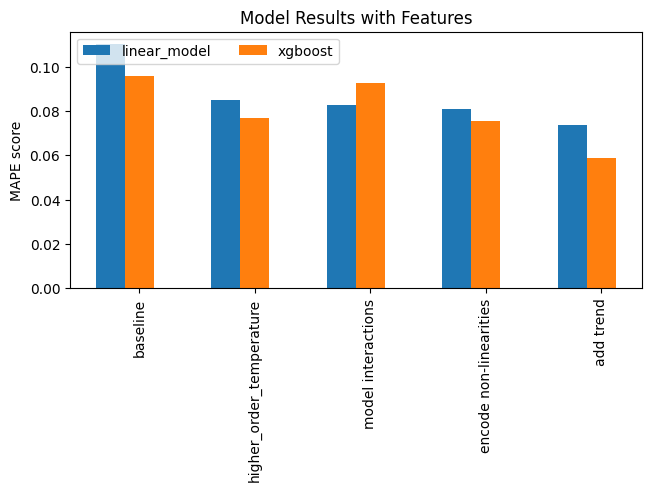

In [10]:
import matplotlib.pyplot as plt
import numpy as np

species = exp_s
penguin_means = models_scores

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for model_name, model_scores in penguin_means.items():
    scores = [model_score[1] for model_score in model_scores]
    offset = width * multiplier
    rects = ax.bar(x + offset, scores, width, label=model_name)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAPE score')
ax.set_title('Model Results with Features')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
# ax.set_ylim(0, 250)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

save_path = proj_root.joinpath('reports/feature_combinations.png')
fig.savefig(fname=save_path)

In [11]:
models_best = {}
for model_name in model_names:
    model_scores = models_scores[model_name]
    scores = [model_score[1] for model_score in model_scores]
    models = [model_score[0] for model_score in model_scores]
    best_score = np.min(scores)
    best_model = models[np.argmin(scores)]
    models_best[model_name] = (best_model, best_score)
models_best

{'linear_model': (Pipeline(steps=[('select_optimal_temperature_columns',
                   OptimalTemperatureSelector(optimal_temperature_column_names_path=PosixPath('/home/aroge/projects/electricity-demand-forecast/models/features/optimal_temperature_columns.pkl'),
                                              temperature_column_names_path=PosixPath('/home/aroge/projects/electricity-demand-forecast/models/features/temperature_col...
                  ('create_trend',
                   DerivedColumnTransformer(column_name='datetime',
                                            derive_func=<function trend at 0x7f466a076440>,
                                            new_column_name='trend')),
                  ('one_hot_categorical_column',
                   ColumsOneHotEncoder(categorical_column_names=['hour',
                                                                 'month'])),
                  ('drop_columns',
                   ColumnsRemover(column_names=['date', 'hour

## Evaluation





transform


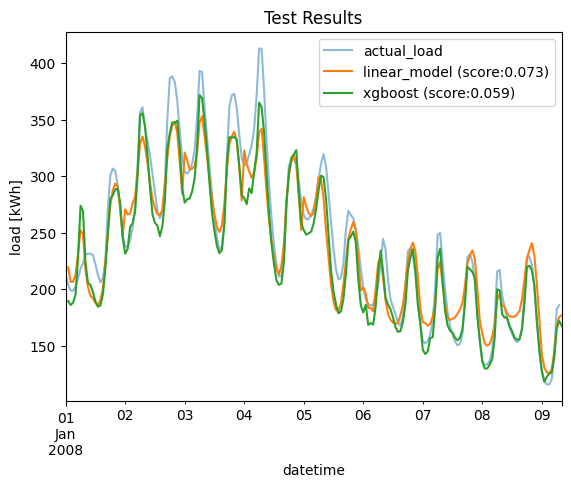

In [14]:
import pandas as pd
from src.preprocessing import preprocessing as prep
from src.inference import inference as inf
from src import utils

proj_root = utils.get_proj_root()

config = utils.get_config('config/config.ini')



raw_temperature_data_path = utils.get_full_path(config['data_paths']['raw_temp_data'])
raw_temperature_data = pd.read_csv(raw_temperature_data_path, parse_dates=[0])
preprocessed_temperature_data = prep.TempDataPreprocessor().fit(raw_temperature_data).transform(raw_temperature_data)
inf_year = 2008
preprocessed_temperature_data = preprocessed_temperature_data[preprocessed_temperature_data.datetime.dt.year >= inf_year]
preprocessed_temperature_data = preprocessed_temperature_data.iloc[1:, :]  # includes first date not in eval
future_dates = preprocessed_temperature_data.datetime #+ p.to_timedelta(preprocessed_temperature_data.datetime.dt.hour, unit='h')



eval_data_path = config['data_paths']['evaluation_data']
actual_load = pd.read_csv(proj_root.joinpath(eval_data_path), parse_dates=[0])
actual_load = prep.LoadDataPreprocessor().fit(actual_load).transform(actual_load)

fig, ax = plt.subplots()
n_pts = 200
start = 0
actual_load[start:n_pts+start].plot(x='datetime', y='load', ax=ax, alpha=0.5, label="actual_load")
for i, model_name in enumerate(model_names):
    model, score = models_best[model_name]
    # model = inf.load_model(model_name=model_name)
    predicted_load = model.predict(preprocessed_temperature_data)

    prediction_data = pd.DataFrame({'datetime':future_dates, 'predicted_load':predicted_load})

    
    prediction_data[start:n_pts+start].plot(x='datetime', y='predicted_load', ls='-', ax=ax, alpha=1, label=f'{model_name} (score:{score:.3f})')
ax.set_ylabel('load [kWh]')
ax.set_title('Test Results')
save_path = proj_root.joinpath('reports/eval.png')
fig.savefig(fname=save_path)